<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/%5BE_06%5D_House_Price_Prediction_KaKR_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Price Predictioin - 2019 ML month KaKR

Goal of this project: 
- 캐글 데이터분석 전과정을 진행해본다
- 전처리, 학습과정 및 결과에 대한 설명을 시각화를 포함하여 체계적으로 진행해본다
- 회귀모델 예측정확도를 110000 이하로 구해본다


* 아직 실력이 많이 부족한것 같아, 오픈된 커널중 몇개를 읽어보고 ***필사*** 로 진행해보았습니다.
- 출처:
  - [ A Note on Using a Single Model: XGBoost](https://www.kaggle.com/ivoryrabbit/a-note-on-using-a-single-model-xgboost) - XGBoost로만 학습
  - [EDA + Stacking modeling](https://www.kaggle.com/bluepinetree/57-of-415-eda-stacking-modeling) - Model Stacking
  - [House Price Prediction EDA](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12) - 좌표와 가격만을 가지고 clustering하던 중에, zipcode를 이용한 평방 대비 가격(price per footage)을 다룸
  - [EDA with Map Visualization](https://www.kaggle.com/fulrose/eda-with-map-visualization?scriptVersionId=12681748) -  데이터 내부의 zipcode와 파이썬 folium 라이브러리를 활용해서 실제 Map Visualization을 해보는 커널

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [13]:
!pip install geojson

In [15]:
!pip install shap

     |████████████████████████████████| 356 kB 5.4 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491643 sha256=edd3ed4afbb4fd61f8c63eb33f53f2dc5f8af813b5c3a0f03769454ed7d3492f
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


In [16]:
# 분석 기본 도구
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# 통계 분석 도구
from scipy import stats

# 시각화 도구
import folium
import geojson
from folium import plugins
from shapely.geometry import shape, Point, multipolygon
from shap import TreeExplainer, summary_plot

# 전처리 도구
from sklearn.preprocessing import LabelEncoder

# 학습 도구
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#import lightgbm as lgb
import xgboost as xgb

# 검증 도구
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#from sklearn.metrics import make_scorer
#from sklearn.metrics import mean_squared_error

# 경고문 무시(seaborn)
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. EDA
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [20]:
train_data_path = join('/content/drive/MyDrive/aiffel/EXP_6_data/kakr-housing-data', 'train.csv')
sub_data_path = join('/content/drive/MyDrive/aiffel/EXP_6_data/kakr-housing-data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(sub_data_path)

print(train.shape)
train.head()

(15035, 21)


id             date     price  ...     long  sqft_living15  sqft_lot15
0   0  20141013T000000  221900.0  ... -122.257           1340        5650
1   1  20150225T000000  180000.0  ... -122.233           2720        8062
2   2  20150218T000000  510000.0  ... -122.045           1800        7503
3   3  20140627T000000  257500.0  ... -122.327           2238        6819
4   4  20150115T000000  291850.0  ... -122.315           1650        9711

[5 rows x 21 columns]

In [21]:
print(test.shape)
test.head()

(6468, 20)


id             date  bedrooms  ...     long  sqft_living15  sqft_lot15
0  15035  20141209T000000         3  ... -122.319           1690        7639
1  15036  20141209T000000         4  ... -122.393           1360        5000
2  15037  20140512T000000         4  ... -122.005           4760      101930
3  15038  20150415T000000         3  ... -122.337           1780        8113
4  15039  20150312T000000         3  ... -122.031           2390        7570

[5 rows x 20 columns]

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

## 1. Check Features

In [24]:
data = pd.merge(train, test, how='outer')

print(data.shape)
data.head()

(21503, 21)


id             date     price  ...     long  sqft_living15  sqft_lot15
0   0  20141013T000000  221900.0  ... -122.257           1340        5650
1   1  20150225T000000  180000.0  ... -122.233           2720        8062
2   2  20150218T000000  510000.0  ... -122.045           1800        7503
3   3  20140627T000000  257500.0  ... -122.327           2238        6819
4   4  20150115T000000  291850.0  ... -122.315           1650        9711

[5 rows x 21 columns]

In [25]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [26]:
data['year'] = data['date'].apply(lambda x:x[:4]).astype(int)
data['month'] = data['date'].apply(lambda x:x[4:6]).astype(int)
data['day'] = data['date'].apply(lambda x:x[6:8]).astype(int)

In [27]:
data['yr_built'].min()

1900

Text(0.5, 0, '')

Text(0.5, 1.0, 'year')

Text(0.5, 0, '')

Text(0.5, 1.0, 'month')

Text(0.5, 0, '')

Text(0.5, 1.0, 'day')

Text(0.5, 0, '')

Text(0.5, 1.0, 'bedrooms')

Text(0.5, 0, '')

Text(0.5, 1.0, 'bathrooms')

Text(0.5, 0, '')

Text(0.5, 1.0, 'floors')

Text(0.5, 0, '')

Text(0.5, 1.0, 'waterfront')

Text(0.5, 0, '')

Text(0.5, 1.0, 'view')

Text(0.5, 0, '')

Text(0.5, 1.0, 'condition')

Text(0.5, 0, '')

Text(0.5, 1.0, 'grade')

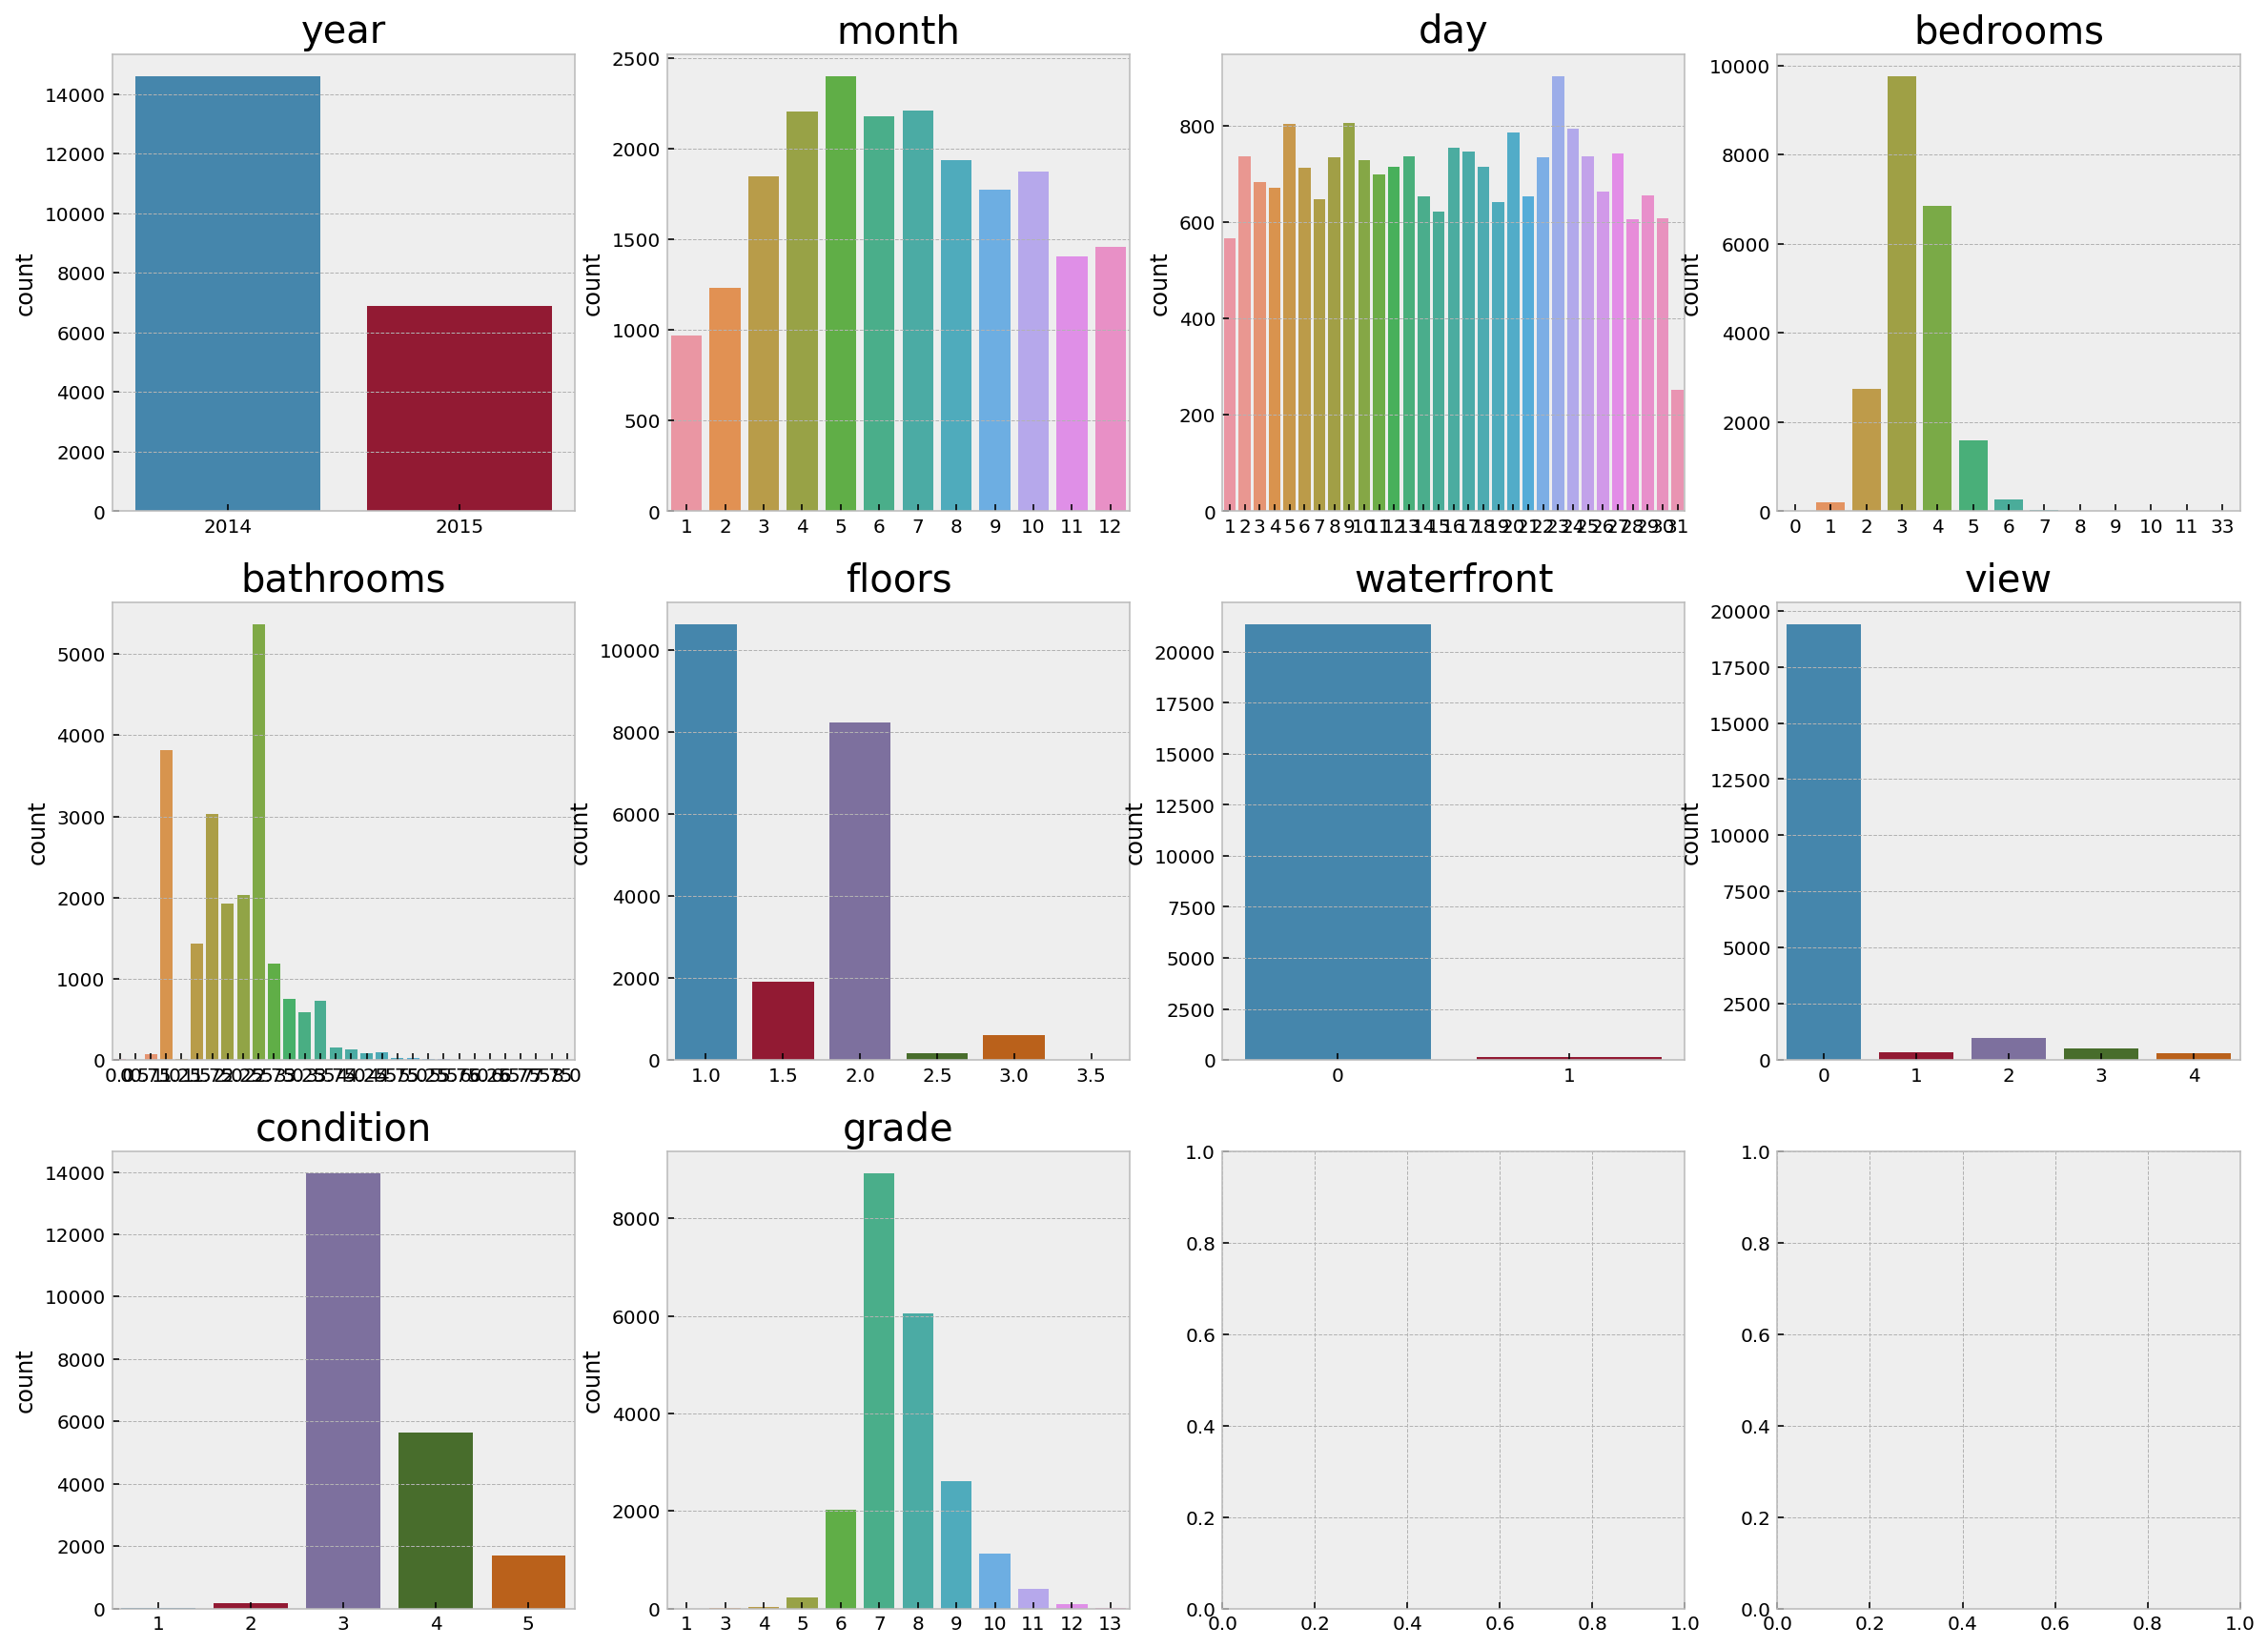

In [28]:
count_info = ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for r in range(3):
    for c in range(4):
        index = 4 * r + c
        if index == len(count_info):
            break
        sns.countplot(data=data, x=count_info[index], ax=axes[r, c])
        axes[r, c].set_xlabel('')
        axes[r, c].set_title(count_info[index], fontsize=20)

바 그래프로 카운트 가능한 칼럼들을 확인해보았습니다.

## 2. Correlation between Discrete Variables

- 데이터는 2014년 5월부터 2015년 5월까지의 집 정보와 가격 정보를 담고 있습니다.
- grade, view, condition에 비례하여 집 가격이 높아지고 있음을 볼 수 있습니다.
- waterfront인지 아닌지에 따른 가격 차이가 존재합니다.
- floors의 소수점은 다락방 등을 의미하는 것으로 보입니다.
- bathrooms

Text(0.5, 0, '')

Text(0.5, 1.0, 'Day')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Month')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Grade')

Text(0.5, 0, '')

Text(0.5, 1.0, 'View')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Condition')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Floors')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Bathrooms')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Bedrooms')

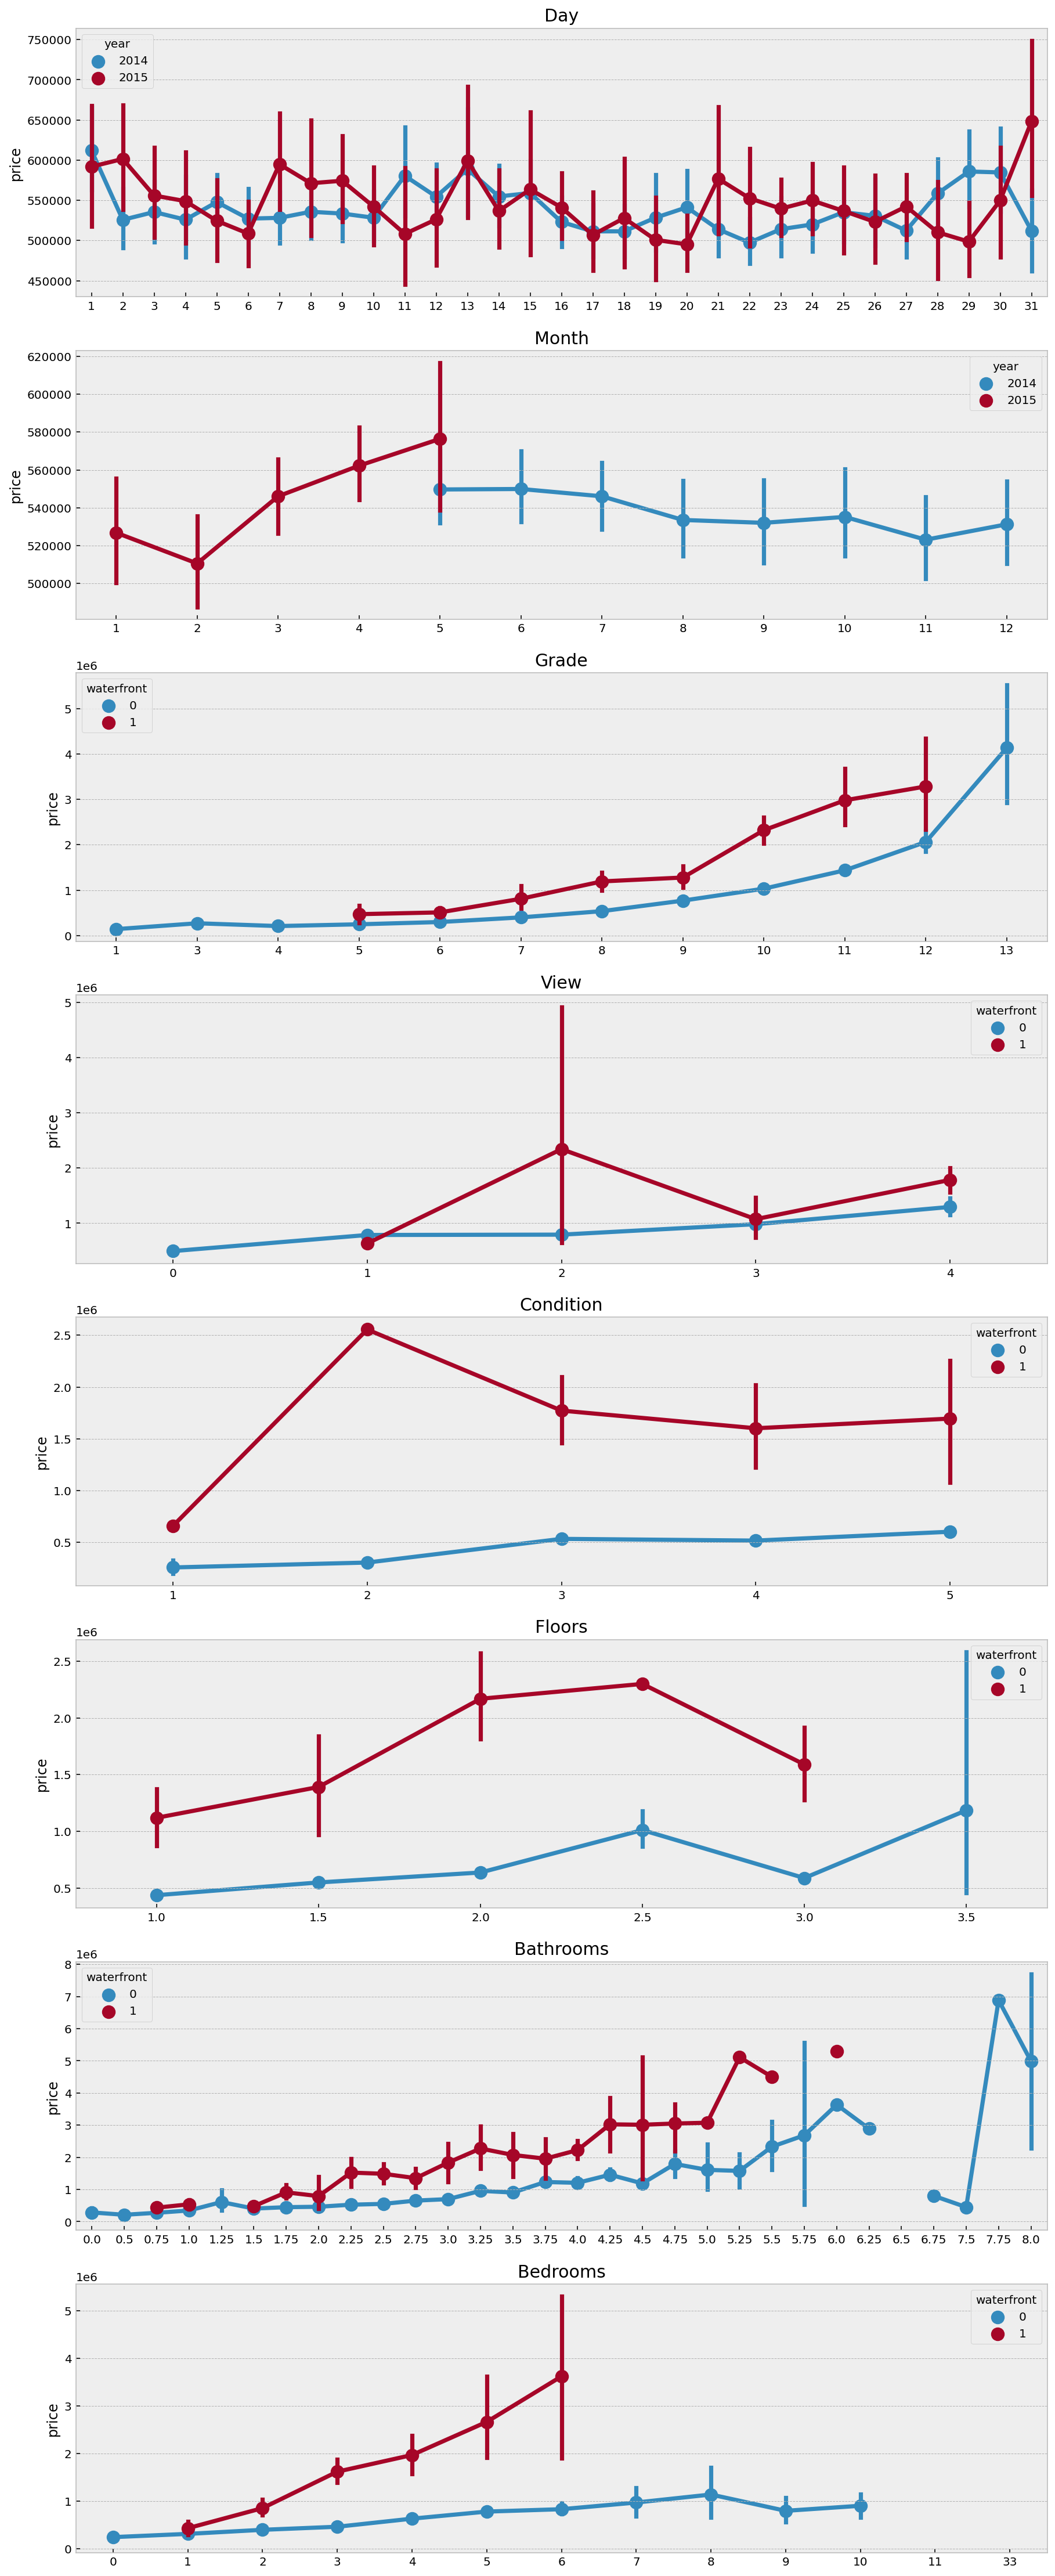

In [29]:
fig, axes = plt.subplots(nrows=8, figsize=(15, 40))

sns.pointplot(data=data, x='day', y='price', hue='year', ax=axes[0])
sns.pointplot(data=data, x='month', y='price', hue='year', ax=axes[1])
sns.pointplot(data=data, x='grade', y='price', hue='waterfront', ax=axes[2])
sns.pointplot(data=data, x='view', y='price', hue='waterfront', ax=axes[3])
sns.pointplot(data=data, x='condition', y='price', hue='waterfront', ax=axes[4])
sns.pointplot(data=data, x='floors', y='price', hue='waterfront', ax=axes[5])
sns.pointplot(data=data, x='bathrooms', y='price', hue='waterfront', ax=axes[6])
sns.pointplot(data=data, x='bedrooms', y='price', hue='waterfront', ax=axes[7])

title = ['Day', 'Month', 'Grade', 'View', 'Condition', 'Floors', 'Bathrooms', 'Bedrooms']
for i in range(8):
    axes[i].set_xlabel('')
    axes[i].set_title(title[i], fontsize=15)
plt.show()

## 3. Correlation between Continuous Variables

- sqft_living은 실질적으로 살 수있는 공간을 뜻합니다.

- sqft_living > sqft_lot인 집이 많은 것으로 보아, sqft_living은 gross floor area로 계산이 되고 있습니다.

  - 만약 어떤 주택의 1층의 면적이 500이고 2층의 면적이 300이라면, sqft_living은 800으로 계산합니다.
  - [참고 링크](https://www.zillow.com/blog/how-to-measure-your-homes-square-footage-92175/)
  - 추가적으로, sqft_living = sqft_above + sqft_basement이며, sqft_basement는 지하실의 면적입니다.
  - sqft_above = 연면적(미국에선 바닥면적)
  - sqft_living을 층 수로 나누어도 여전히 sqft_lot보다 큰 집들이 있습니다.
- 건축 관련 수치들:

  - 건폐율(building coverage) = 건축면적 / 대지면적
  - 연면적(floor area ratio) = 연면적(바닥면적) / 대지면적
- sqft_lot과 sqft_lot15은 단일 속성으로서 price와 상관관계가 적은 것으로 보입니다.

                  price  sqft_living  ...  sqft_living15  sqft_lot15
price          1.000000     0.702899  ...       0.586419    0.086384
sqft_living    0.702899     1.000000  ...       0.760271    0.184176
sqft_lot       0.096793     0.176500  ...       0.147562    0.728458
sqft_above     0.608577     0.878736  ...       0.737795    0.194226
sqft_basement  0.322218     0.434017  ...       0.198380    0.018813
sqft_living15  0.586419     0.760271  ...       1.000000    0.183599
sqft_lot15     0.086384     0.184176  ...       0.183599    1.000000

[7 rows x 7 columns]


Text(0.5, 1.0, 'Correlation Matters')

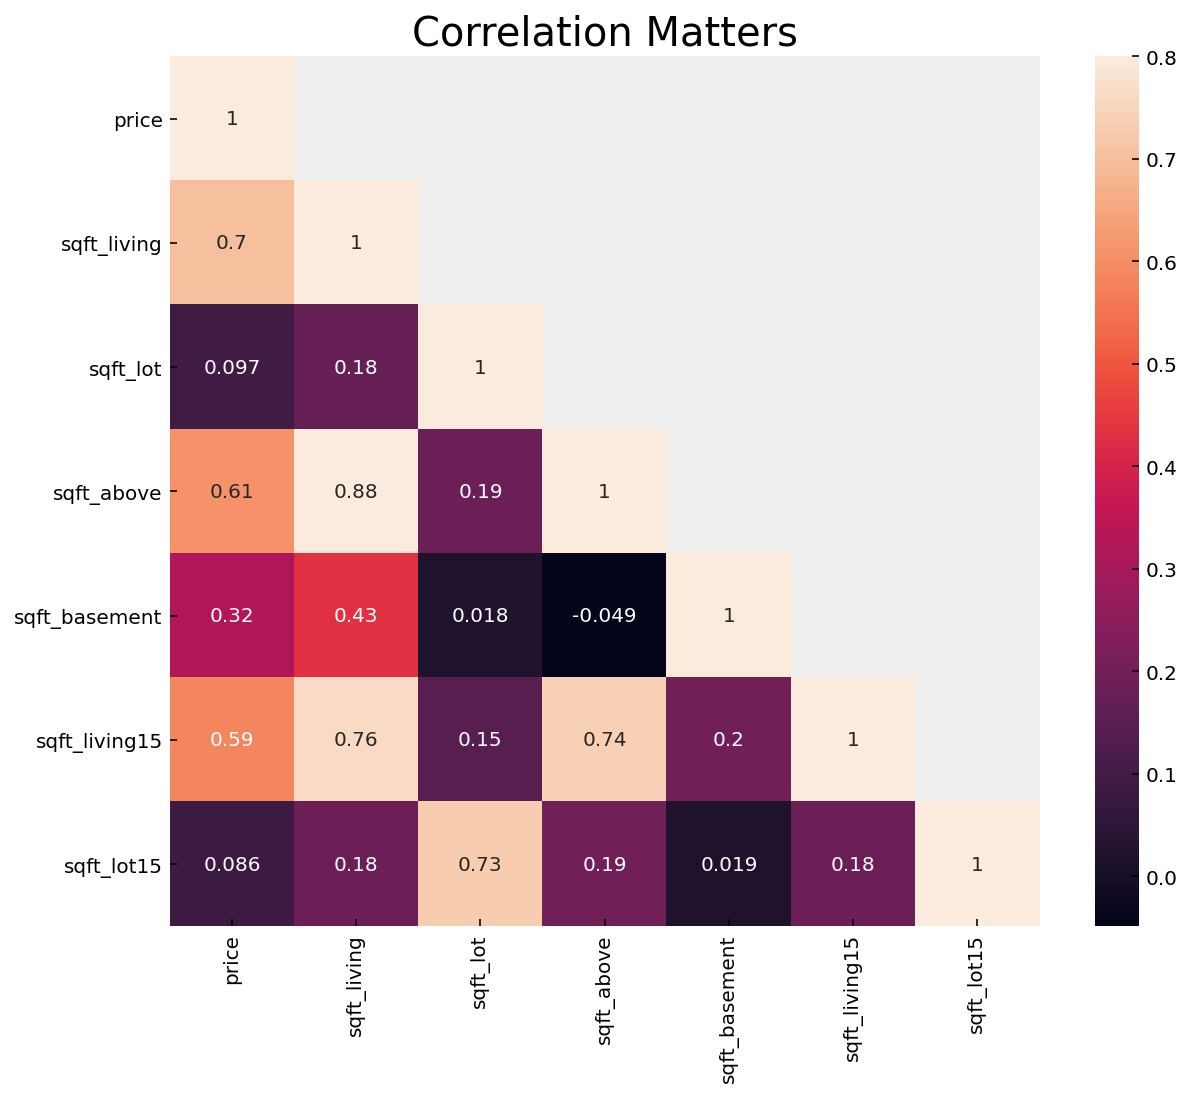

In [30]:
corrMatt = train[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]
corrMatt = corrMatt.corr()

print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)
ax.set_title('Correlation Matters', fontsize=20)
plt.show()

## 4. Distribution of Price

and log scaling
- log scaling(1을 더한 후 log)한 후에 normal distribution에 더욱 가까워지는 것을 확인할 수 있습니다.

Text(0.5, 1.0, 'Before Log Scaling')

Text(0.5, 1.0, 'After Log Scaling')

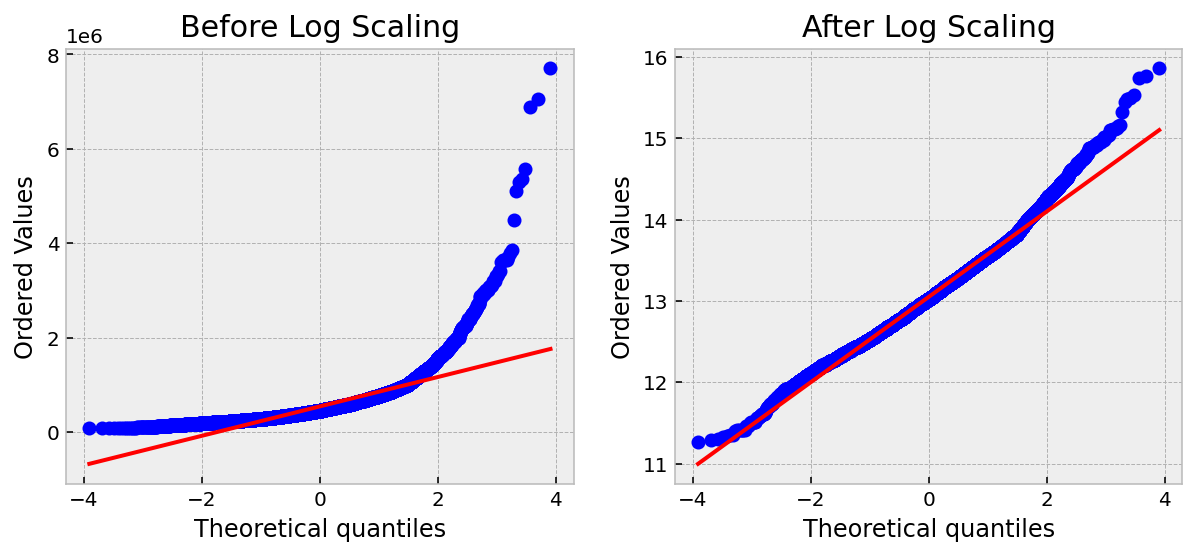

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

## 5. GeoJSON

데이터 내부의 zipcode와 파이썬 folium 라이브러리를 활용해서 실제 Map Visualization을 해보는 부분도 같이 필사해보았습니다. geojson 파일과 zipcode_data 은 또 다른 분들의 커널에서 받아왔습니다.   
zipcode 데이터를 이용해 각 zipcode별로 가격 분포를 확인해볼 수 있습니다.   
   
제가 시애틀의 Bellevue 지역에 살았어서 친근감이 듭니다..!

In [35]:
geo_zipcode_path = join('/content/drive/MyDrive/aiffel/EXP_6_data/', 'zipcode_king_county.geojson')
zipcode_data_path = join('/content/drive/MyDrive/aiffel/EXP_6_data/', 'zipcode_data.csv')

In [36]:
geo_zipcode = geojson.load(open(geo_zipcode_path, encoding='utf-8'))

def zipcode(coord):
    point = Point(coord)
    for feature in geo_zipcode['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['ZCTA5CE10']
    return 'Outlier'

In [37]:
zipcode_data = pd.read_csv(zipcode_data_path, index_col=None, header=0, encoding='utf-8')

print(zipcode_data.shape)
zipcode_data.head()

(15035, 3)


price zipcode                coord
0  221900.0   98178  (-122.257, 47.5112)
1  180000.0   98028  (-122.233, 47.7379)
2  510000.0   98074  (-122.045, 47.6168)
3  257500.0   98003  (-122.327, 47.3097)
4  291850.0   98198  (-122.315, 47.4095)

In [39]:
zipcode = pd.pivot_table(zipcode_data, index=['zipcode'])

In [40]:
map_price = folium.Map(location=[train['lat'].mean(), train['long'].mean()],
                       min_zoom=8, # 고정
                       max_zoom=10,
                       tiles='OpenStreetMap',
                       width=960,
                       height=540,
                      )

folium.Choropleth(
    geo_data=geo_zipcode, 
    data=zipcode['price'],
    columns=[zipcode.index, zipcode['price']],
    fill_color='Reds',
    fill_opacity=0.5,
    line_opacity=0.8,
    key_on='feature.properties.ZCTA5CE10',
).add_to(map_price)

map_price

역시나.. 시애틀 도시 바로 오른쪽즈음이 집값이 제일 비쌉니다. Bellevue지역도 걸쳐서요.    
저 지역이 비싼 이유는 저기가 한국의 8학군(?) 으로 비교가 되는 지역으로 교육열이 아주 쎈 지역이기 때문입니다. 최근에는 MS AWS 등등 IT 대기업들이 건물을 많이 지어서 땅값이 (아주 아주 아주 아주) 많이 올랐습니다.

**sqft_living, sqft_living15, sqft_lot, sqft_lot15**    
주거공간의 평방미터와 부지(땅)의 평방피트를 의미합니다.
위 feature와 sqft_lot(부지의 평방미터)와의 차이는 아마 집앞 마당의 유무와, 크기의 차이가 아닐까 생각합니다.   
(매우 중요한 feature로 사용될 수 있을거 같아요)

# 2. Preprocess

## 1. Feature Engineering
- 좌zipcode를 이용한 평방 대비 가격(price per footage) - Hyun woo Kim님의 kernel을 참고

- 연도를 쓰지 않고 2014년 5월부터 2015년 5월까지의 시간을 열 세달(1~13)로 쪼개어 재정렬  → 
- 건축 관련 수치 추가

  - floor_area_ratio(sqft_living / sqft_lot) 추가  →  성능 상승
  - building_coverage(sqft_above / (floor * sqft_lot)) 추가  →  효과 없었음
  - 그 외 여러가지 시도
- 지하실 유무, 다락방 유무, 재건축 유무 등에 대한 feature를 추가할 수도 있으나 효과 없었음

  - feature의 개수가 많아져서 model complexity가 증가하면 overfitting이 강력해지기 때문으로 추측
- 방 관련 feature 추가

  - 방 총 개수 추가  →  효과 없었음
- sqft_lot15 제거  →  상황마다 다른 걸로 결론

- how_old: 건물이 건축되고 리모델링 된 후, 팔리기까지 걸린 시간

- yr_renovated 제거

## 2. Log Scaling
- sqft 관련 수치에 대해 log scaling

## 3. Label Encoding
- zipcode에 Label Encoding
- yr_built = yr_built - 1900 적용

In [41]:
le = LabelEncoder()
le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

LabelEncoder()

LabelEncoder()

In [42]:
train['price_per_land_area'] = train['price'] / (train['sqft_living'])
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()

train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')

del train['price_per_land_area']

In [43]:
X_train = train.drop(['id', 'price'], axis=1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id'], axis=1)

In [44]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'count', 'mean', 'std'],
      dtype='object')

In [ ]:
# Adding features
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)
    del df['date']
    del df['yr_renovated']
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_floor'] = df['sqft_above'] / df['floors']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15']

Text(0.5, 1.0, 'bedrooms')

Text(0.5, 1.0, 'bathrooms')

Text(0.5, 1.0, 'sqft_living')

Text(0.5, 1.0, 'sqft_lot')

Text(0.5, 1.0, 'floors')

Text(0.5, 1.0, 'waterfront')

Text(0.5, 1.0, 'view')

Text(0.5, 1.0, 'condition')

Text(0.5, 1.0, 'grade')

Text(0.5, 1.0, 'sqft_above')

Text(0.5, 1.0, 'sqft_basement')

Text(0.5, 1.0, 'yr_built')

Text(0.5, 1.0, 'zipcode')

Text(0.5, 1.0, 'lat')

Text(0.5, 1.0, 'long')

Text(0.5, 1.0, 'sqft_living15')

Text(0.5, 1.0, 'count')

Text(0.5, 1.0, 'mean')

Text(0.5, 1.0, 'std')

Text(0.5, 1.0, 'date(new)')

Text(0.5, 1.0, 'how_old')

Text(0.5, 1.0, 'sqft_floor')

Text(0.5, 1.0, 'floor_area_ratio')

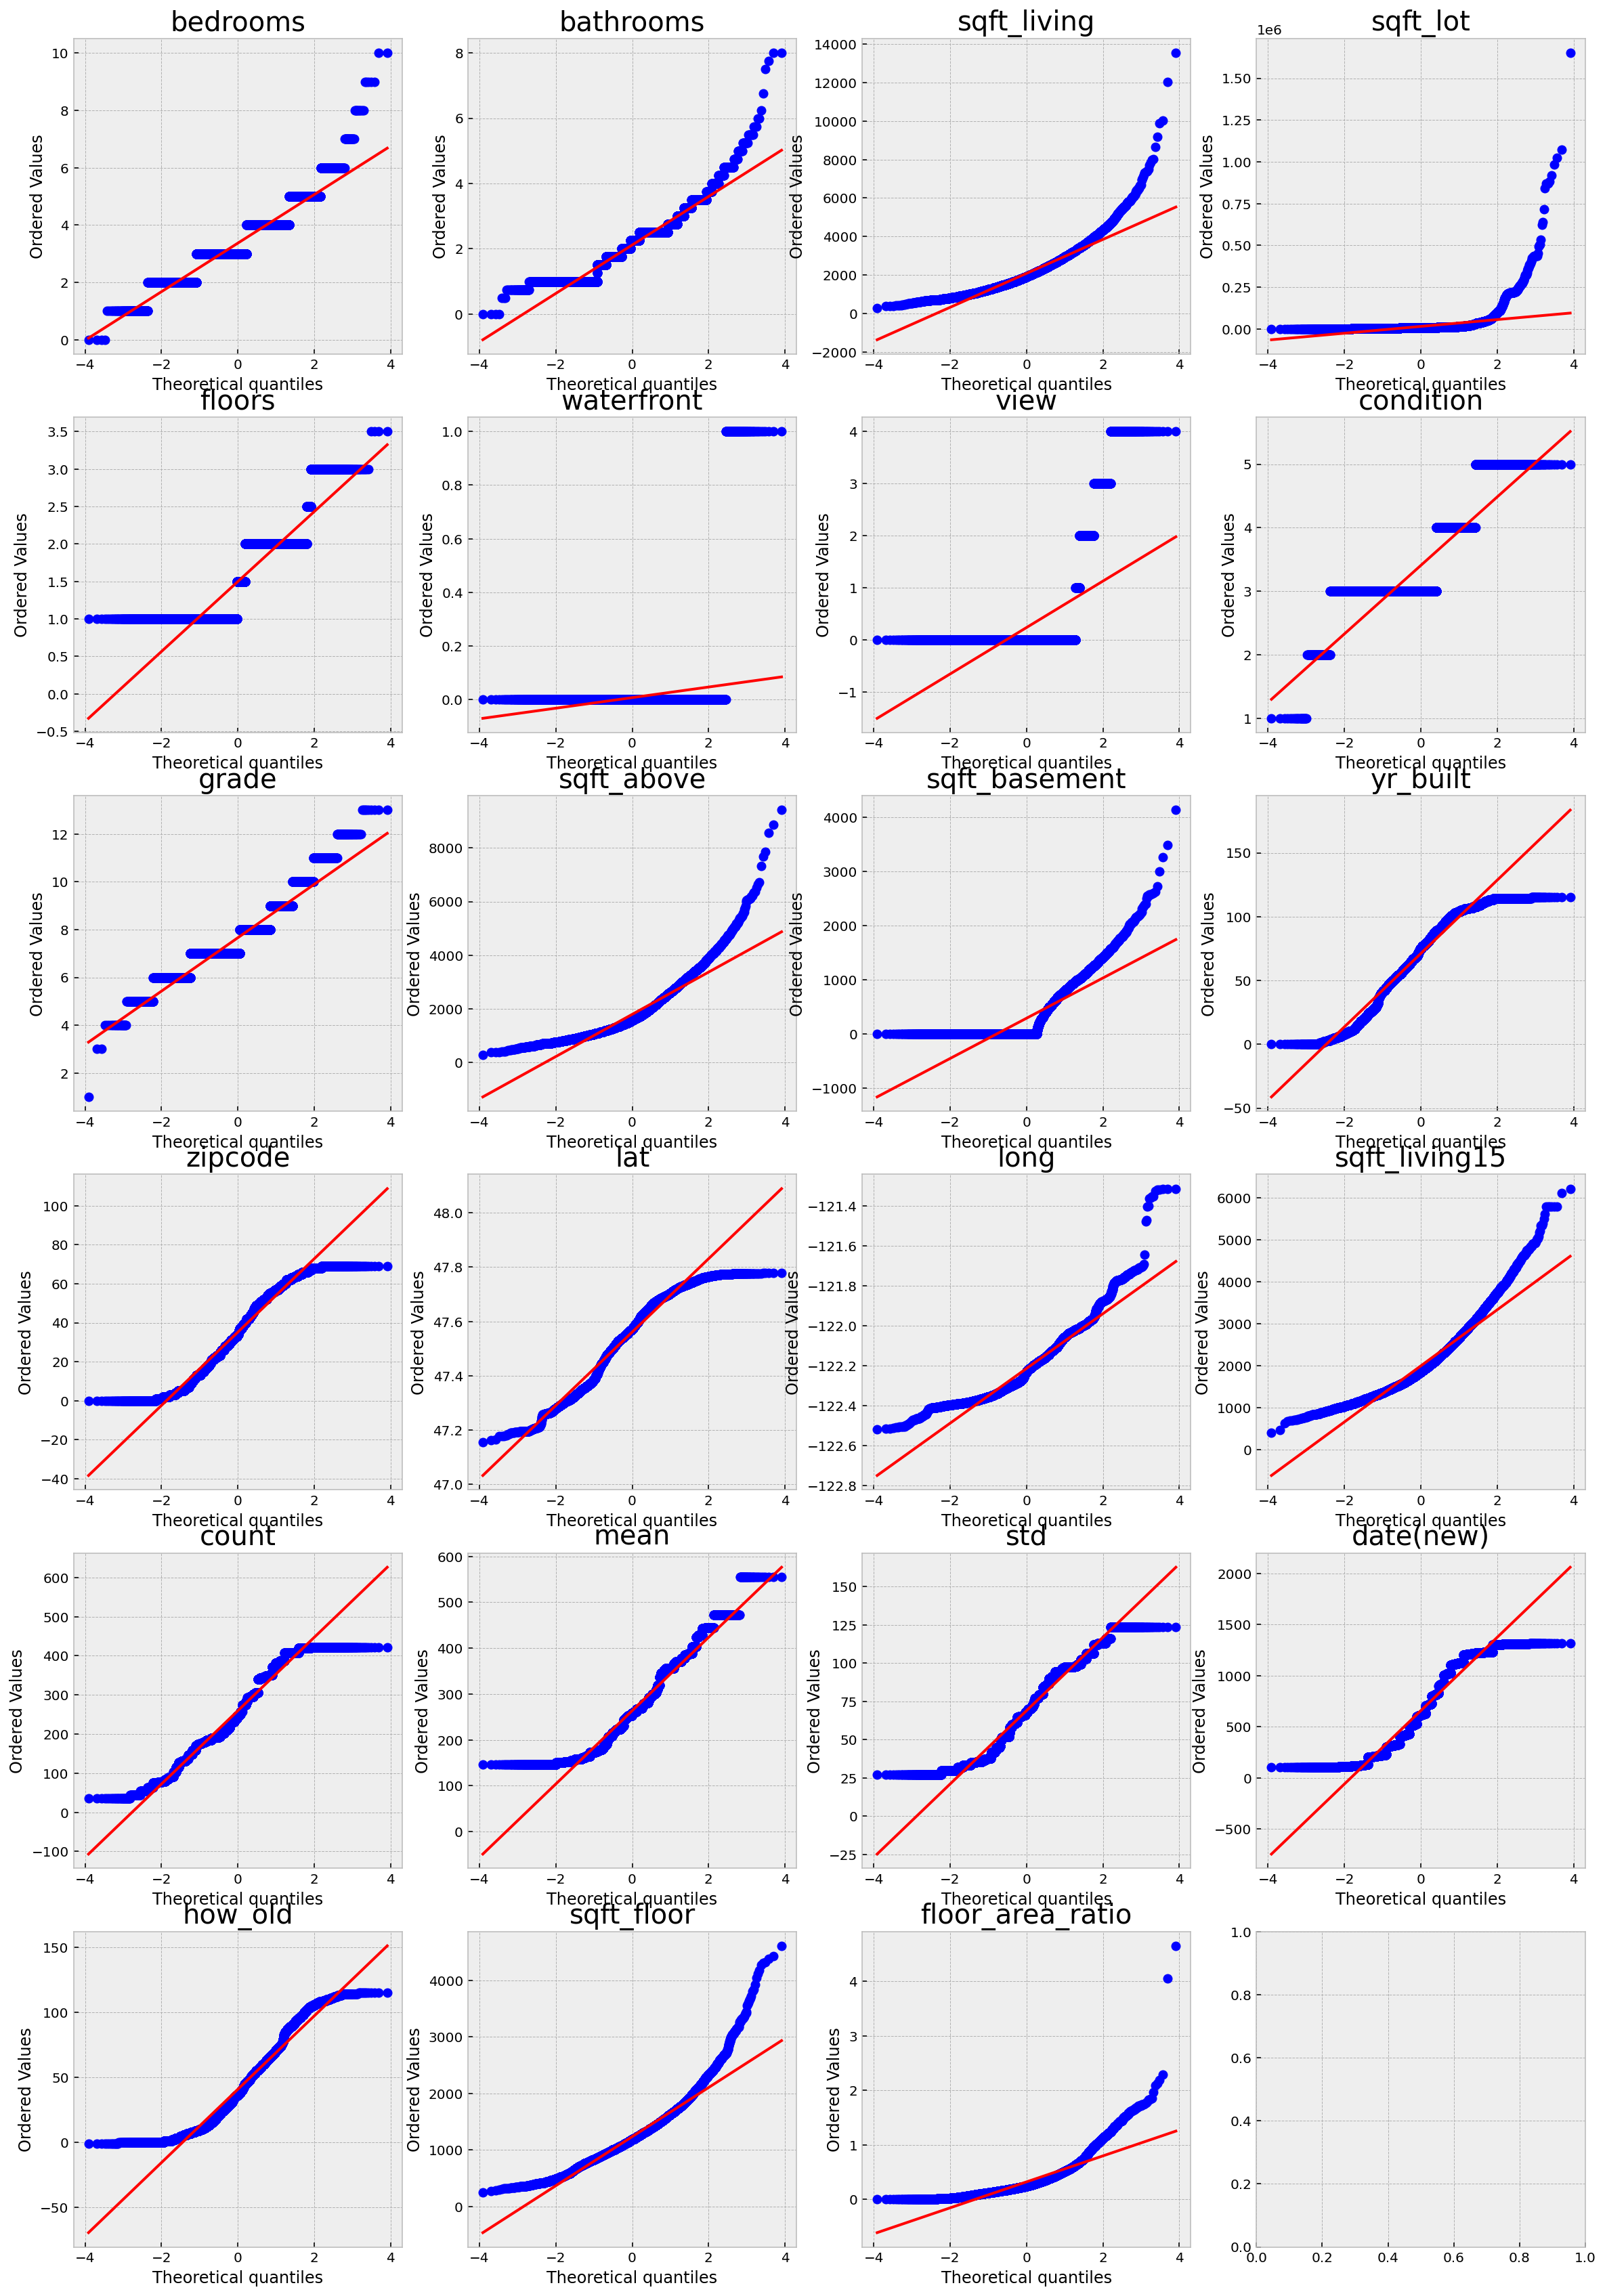

In [48]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

In [49]:
# Log Scaling
log_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_floor', 'mean', 'floor_area_ratio', 'floor_area_ratio']
for feature in log_features:
    for df in [X_train, X_test]:
        df[feature] = np.log1p(df[feature])

Text(0.5, 1.0, 'bedrooms')

Text(0.5, 1.0, 'bathrooms')

Text(0.5, 1.0, 'sqft_living')

Text(0.5, 1.0, 'sqft_lot')

Text(0.5, 1.0, 'floors')

Text(0.5, 1.0, 'waterfront')

Text(0.5, 1.0, 'view')

Text(0.5, 1.0, 'condition')

Text(0.5, 1.0, 'grade')

Text(0.5, 1.0, 'sqft_above')

Text(0.5, 1.0, 'sqft_basement')

Text(0.5, 1.0, 'yr_built')

Text(0.5, 1.0, 'zipcode')

Text(0.5, 1.0, 'lat')

Text(0.5, 1.0, 'long')

Text(0.5, 1.0, 'sqft_living15')

Text(0.5, 1.0, 'count')

Text(0.5, 1.0, 'mean')

Text(0.5, 1.0, 'std')

Text(0.5, 1.0, 'date(new)')

Text(0.5, 1.0, 'how_old')

Text(0.5, 1.0, 'sqft_floor')

Text(0.5, 1.0, 'floor_area_ratio')

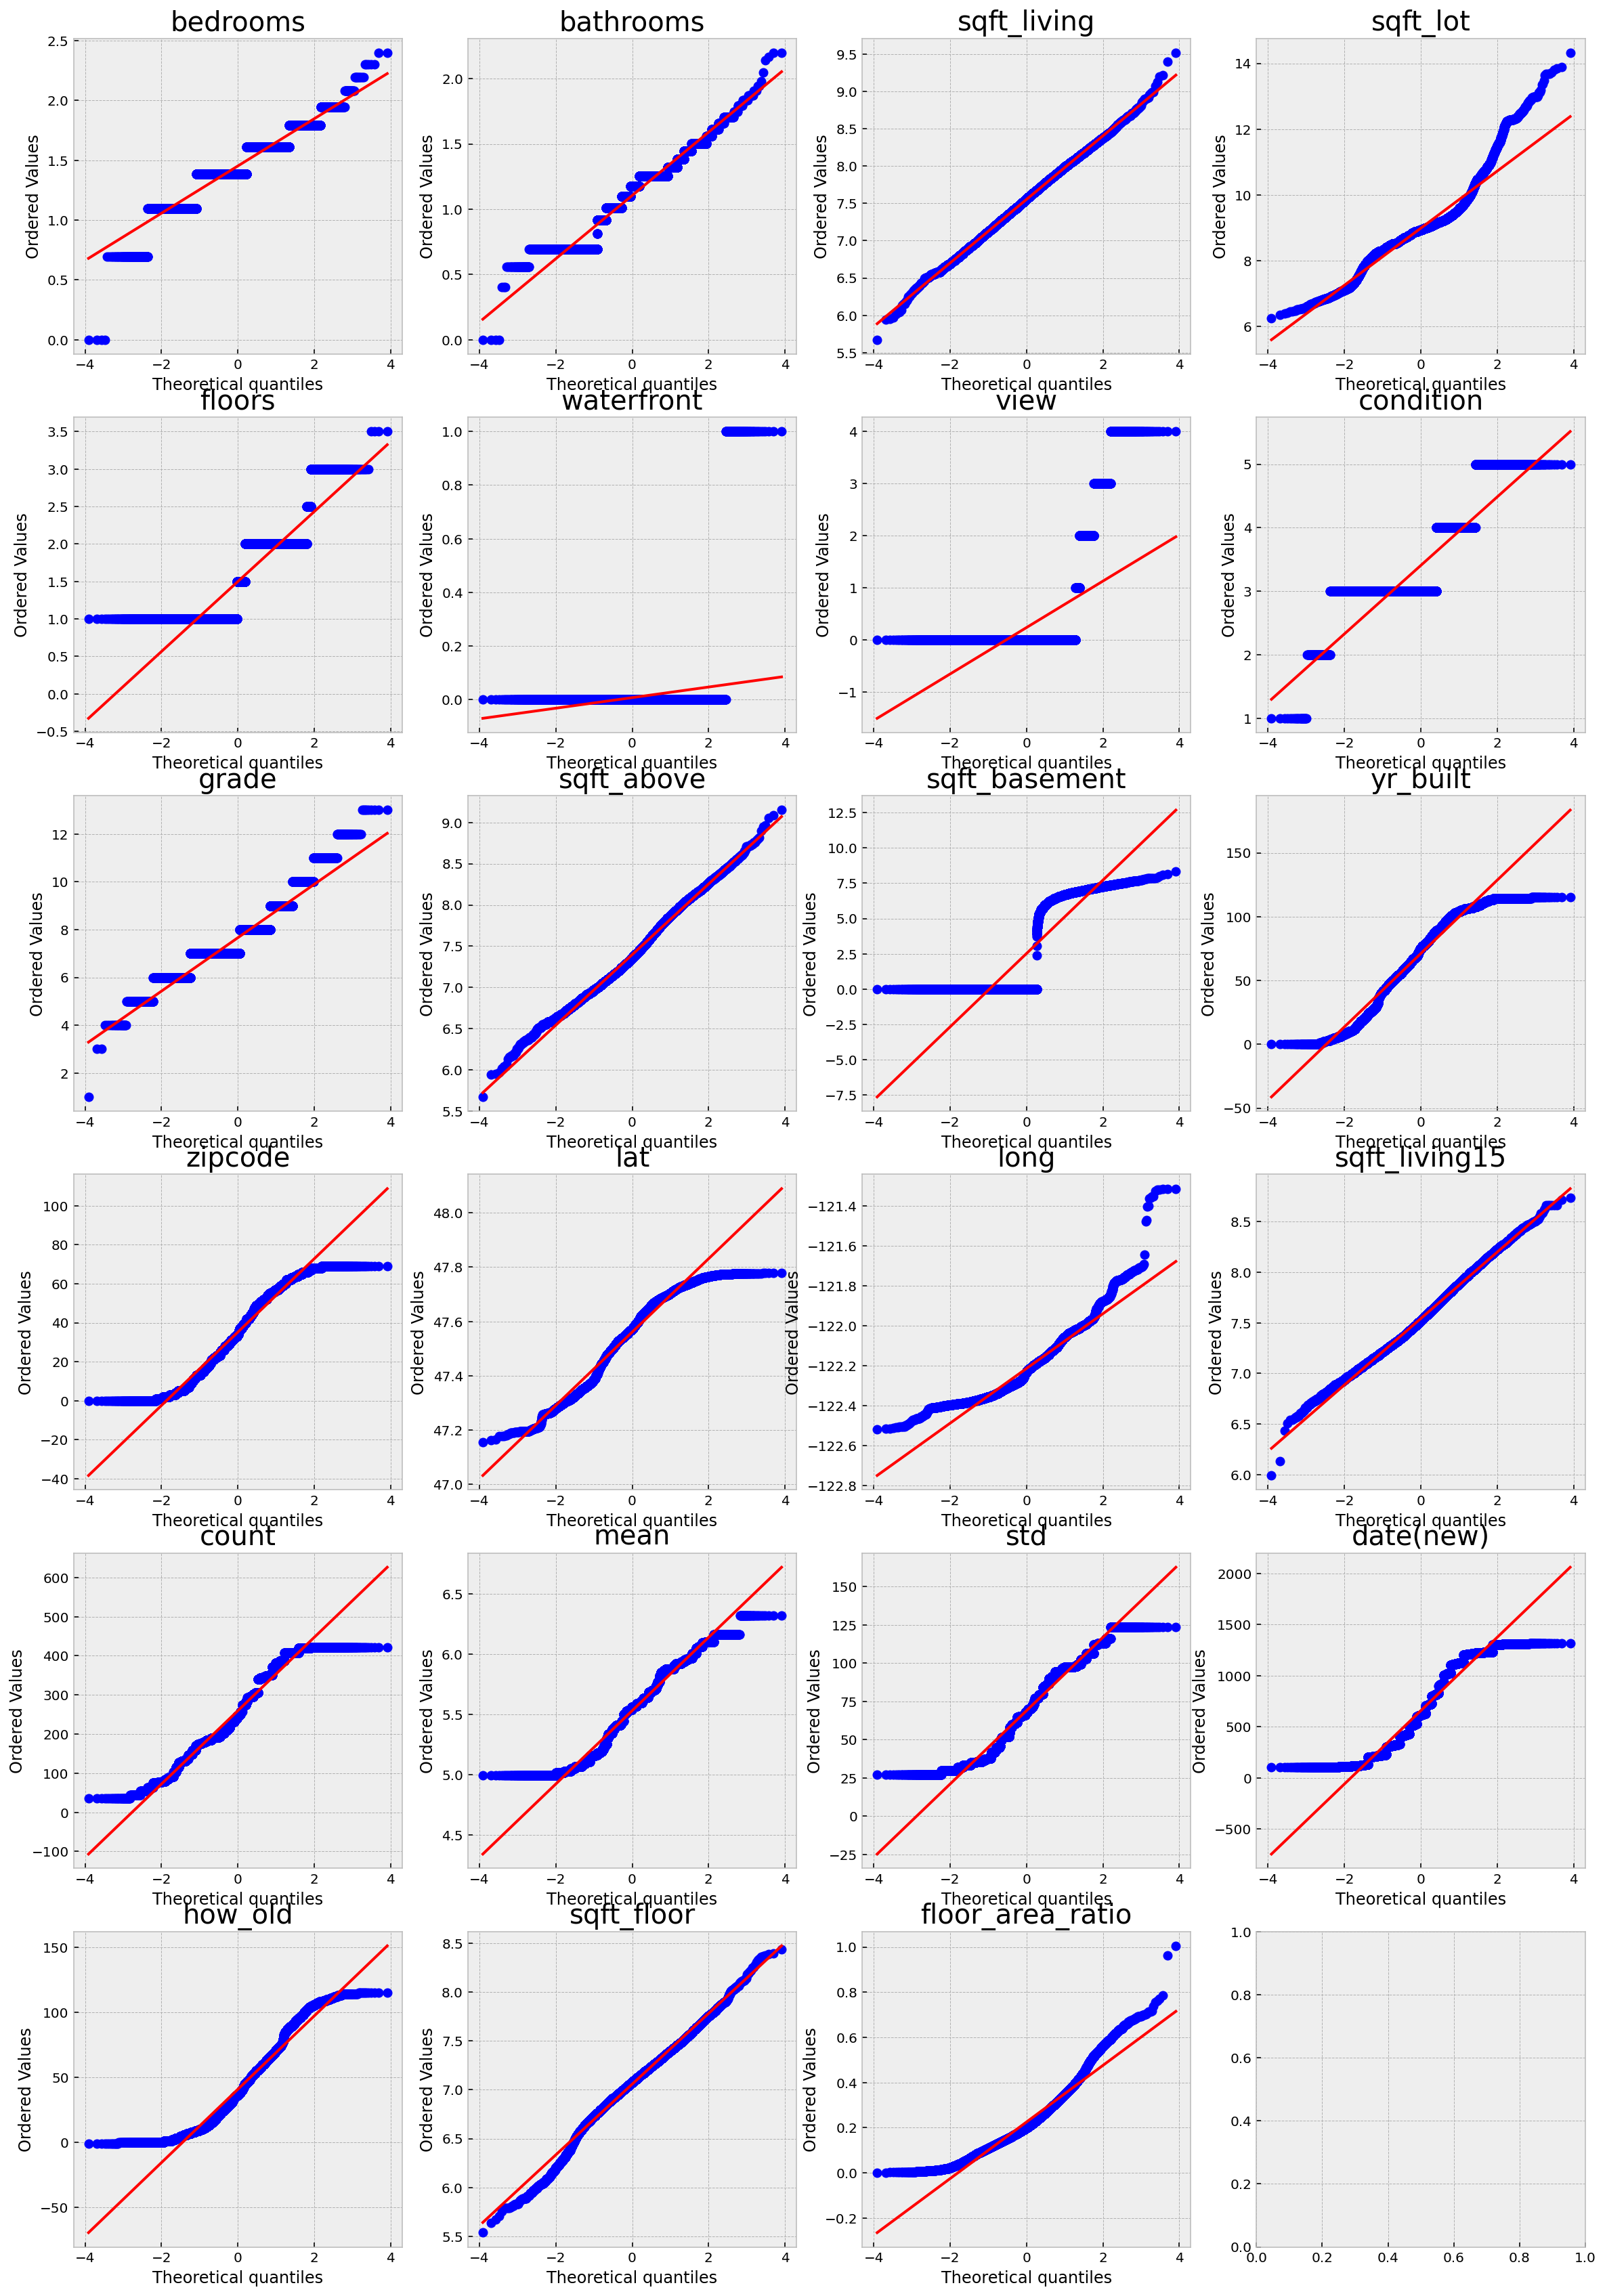

In [50]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

# 3. Learning

- xgboost 하나의 모델만을 이용해 학습해보겠습니다.
- 평가 척도는 RMSE(Root Mean Square Error)입니다.


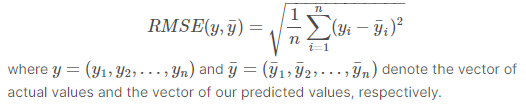

In [52]:
# feval function에 사용하기 위해
def rmse_exp(predictions, dmat):
    labels = dmat.get_label()
    error = np.expm1(predictions) - np.expm1(labels)
    squared_error = np.square(error)
    mean = np.mean(squared_error)
    return ('rmse_exp', np.sqrt(mean))

## 1. Hyperparameter

- 튜닝에는 Grid Search 사용

In [53]:
xgb_params = {
    'eta': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.4,
#     'tree_method': 'gpu_hist',    # 최적화된 분할 지점을 찾기 위한 algorithm 설정 + 캐글의 GPU 사용
#     'predictor': 'gpu_predictor', # 예측 시에도 GPU사용
    'objective': 'reg:linear',    # 회귀
    'eval_metric': 'rmse',        # kaggle에서 요구하는 검증모델
    'silent': True,               # 학습 동안 메세지 출력할지 말지
    'seed': 4777,
}

##2. Validation
우리는 price 대신  $log(price+1)$ 을 사용했으므로, scoring을 할 때 feval function을 이용하여  $exp(y¯)−1$ 를 취해줍니다.

[0]	train-rmse:12.3084	train-rmse_exp:656012	test-rmse:12.3084	test-rmse_exp:655932
[100]	train-rmse:1.65059	train-rmse_exp:557806	test-rmse:1.65134	test-rmse_exp:558036
[200]	train-rmse:0.275392	train-rmse_exp:209181	test-rmse:0.282708	test-rmse_exp:217123
[300]	train-rmse:0.153409	train-rmse_exp:109547	test-rmse:0.171343	test-rmse_exp:132265
[400]	train-rmse:0.141242	train-rmse_exp:91231.8	test-rmse:0.164989	test-rmse_exp:120696
[500]	train-rmse:0.133804	train-rmse_exp:83935.7	test-rmse:0.162581	test-rmse_exp:117194
[600]	train-rmse:0.127573	train-rmse_exp:78847.5	test-rmse:0.160953	test-rmse_exp:115318
[700]	train-rmse:0.122248	train-rmse_exp:74935.1	test-rmse:0.15977	test-rmse_exp:114138
[800]	train-rmse:0.117631	train-rmse_exp:71638.1	test-rmse:0.158951	test-rmse_exp:113239
[900]	train-rmse:0.113469	train-rmse_exp:68614.5	test-rmse:0.158407	test-rmse_exp:112782
[1000]	train-rmse:0.109638	train-rmse_exp:66082.2	test-rmse:0.157973	test-rmse_exp:112418
[1100]	train-rmse:0.106036	trai

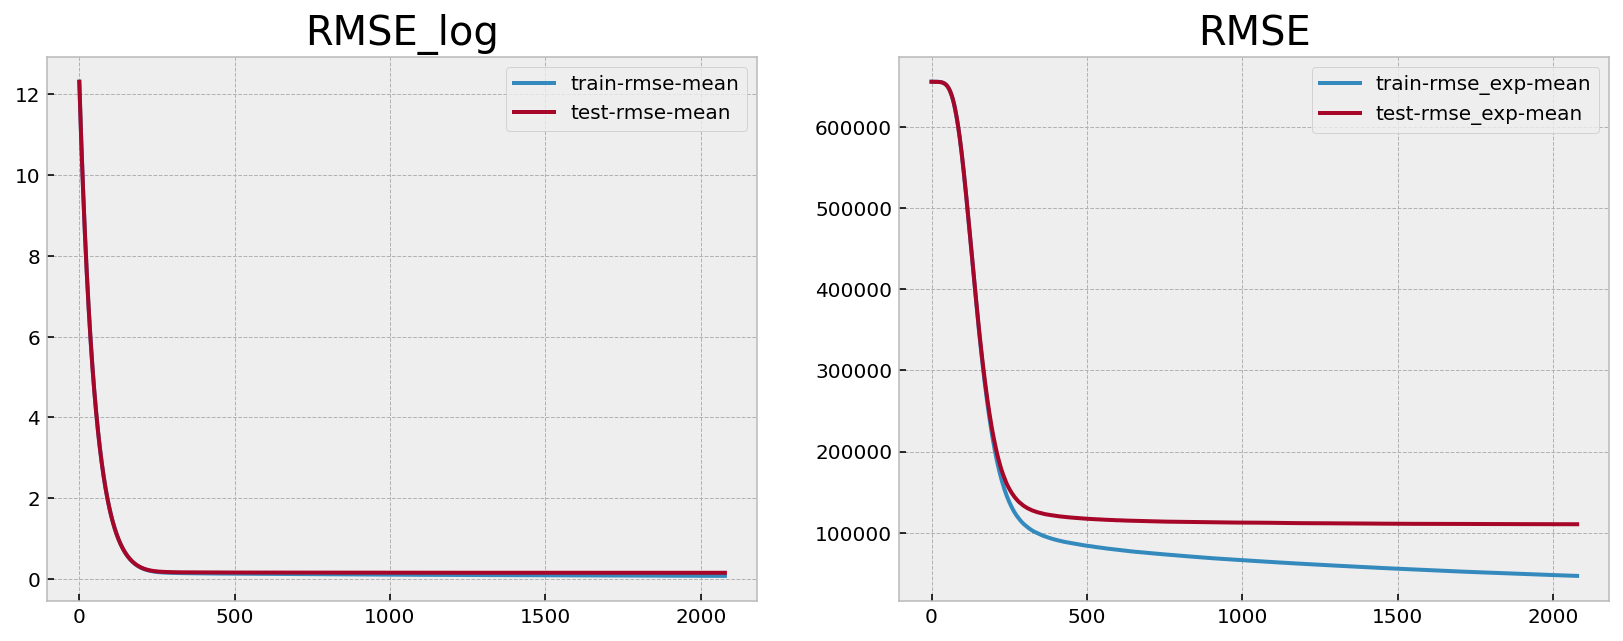

CPU times: user 5min 17s, sys: 1.44 s, total: 5min 19s
Wall time: 2min 43s


In [54]:
%%time
# transforming
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

# cross validation
cv_output = xgb.cv(xgb_params,
                   dtrain,                        
                   num_boost_round=5000,         # the number of boosting trees
                   early_stopping_rounds=100,    # val loss가 계속 상승하면 중지
                   nfold=5,                      # set folds of the closs validation
                   verbose_eval=100,             # 몇 번째마다 메세지를 출력할 것인지
                   feval=rmse_exp,               # price 속성을 log scaling 했기 때문에, 다시 exponential
                   maximize=False,
                   show_stdv=False,              # 학습 동안 std(표준편차) 출력할지 말지
                   )

# scoring
best_rounds = cv_output.index.size
score = round(cv_output.iloc[-1]['test-rmse_exp-mean'], 2)

print(f'\nBest Rounds: {best_rounds}')
print(f'Best Score: {score}')


# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot(ax=ax1)
ax1.set_title('RMSE_log', fontsize=20)
cv_output[['train-rmse_exp-mean', 'test-rmse_exp-mean']].plot(ax=ax2)
ax2.set_title('RMSE', fontsize=20)

plt.show()

## 3.
마찬가지로 예측값에도  $exp(y¯)−1$ 를 취해줍니다.


In [55]:
model = xgb.train(xgb_params, dtrain, num_boost_round=best_rounds)
y_pred = model.predict(dtest)
y_pred = np.expm1(y_pred)

## 4. Feature Importance
- waterfront는 feature importance가 낮은데도 불구하고 시각화나 실험단계에서 집 가격에 상당한 영향을 미치는 것을 확인하였는데, 이는 waterfront인 집과 아닌 집의 수 차이가 많이 나기 때문으로 생각합니다.
- EDA에서 sqft_lot 속성은 price와 낮은 관계성을 보였는데, feature importance에서는 굉장히 높은 중요도를 띕니다.

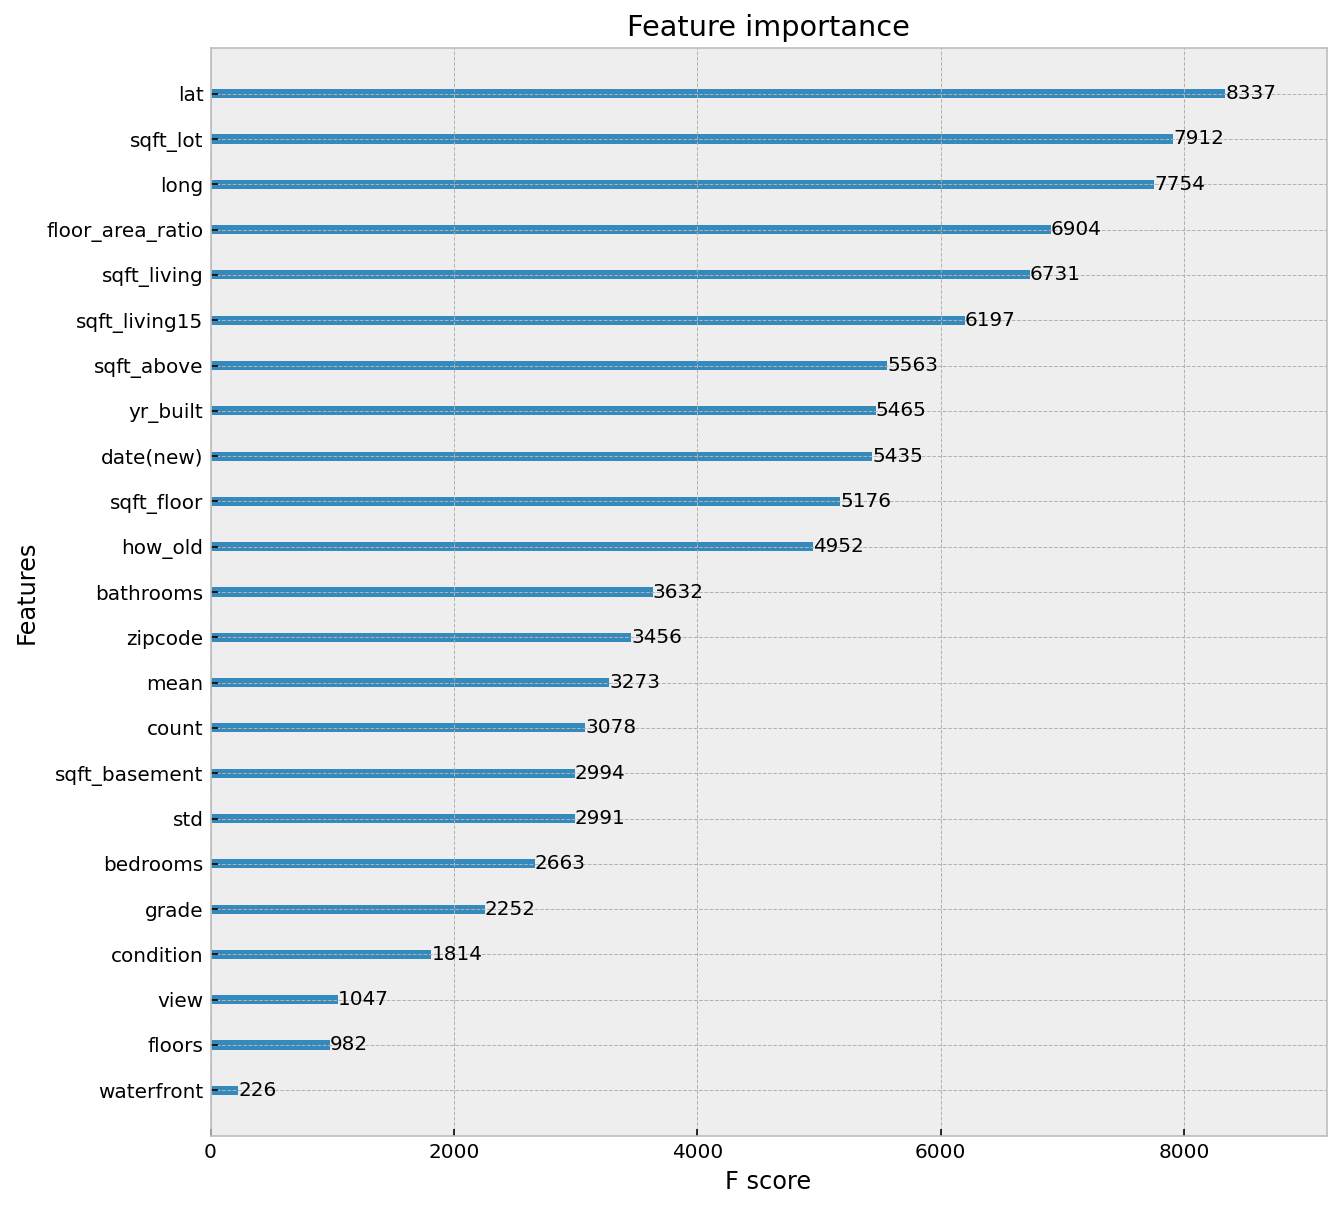

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

plt.show()

# Submission
- submission sample를 확인하고 그 양식에 맞게 submission 파일을 만들어 제출합니다.

In [57]:
sample_submission_data_path = join('/content/drive/MyDrive/aiffel/EXP_6_data/kakr-housing-data', 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_data_path)

print(sample_submission.shape)
sample_submission.head()

(6468, 2)


id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [58]:
submission = pd.DataFrame(data = {'id': test['id'], 'price': y_pred})

print(submission.shape)
submission.head()

(6468, 2)


id         price
0  15035  5.394252e+05
1  15036  4.693351e+05
2  15037  1.422978e+06
3  15038  3.080708e+05
4  15039  3.247881e+05

In [60]:
submission.to_csv('/content/drive/MyDrive/aiffel/EXP_6_data/submission.csv', index=False)

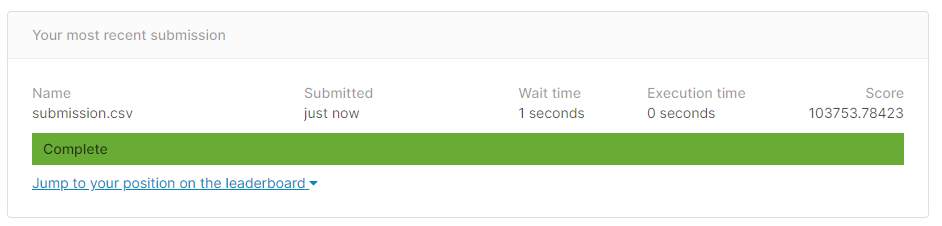

# Conlcusion
## Things I've learned
- EDA processes with chekcing features, correlation btn discrete variables & continuous variables
- Cheking GeoJSON data with plotting data on the map.
- Apply XGBoost
- Log Scaling
- Label Encodiing
- Feature Engineering in a real dataset.

## Challenges I've faced.
- 혼자 시도해보았을대는 score를 낮추기가 많이 어렵다는 생각을 했습니다.
- 아직 부족하다는 생각을 하며 필사로 진행해보았는데, 확실히 zipcode를 기준으로 삼는 인사이트에서 많이 배웠고, correlatioin을 찾고 feature engineering의 좋은 예를 공부하게되어서 좋았습니다.



# References
  - [ A Note on Using a Single Model: XGBoost](https://www.kaggle.com/ivoryrabbit/a-note-on-using-a-single-model-xgboost) - XGBoost로만 학습
  - [EDA + Stacking modeling](https://www.kaggle.com/bluepinetree/57-of-415-eda-stacking-modeling) - Model Stacking
  - [House Price Prediction EDA](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12) - 좌표와 가격만을 가지고 clustering하던 중에, zipcode를 이용한 평방 대비 가격(price per footage)을 다룸
  - [EDA with Map Visualization](https://www.kaggle.com/fulrose/eda-with-map-visualization?scriptVersionId=12681748) -  데이터 내부의 zipcode와 파이썬 folium 라이브러리를 활용해서 실제 Map Visualization을 해보는 커널